# Load all packages

In [5]:
## general
import numpy as np
import datetime
from sklearn.externals import joblib
import copy
import cf_units
import xarray as xr
import os
import sys
from tqdm import tqdm_notebook as tqdm
import datetime as dt


## statistics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy import stats
from scipy.stats import multivariate_normal # to compute likelihood
from scipy.optimize import curve_fit, fmin
from sklearn.preprocessing import StandardScaler
from pygam import LinearGAM, s, te, f

# statistics which aren't all that nice in python
import rpy2.robjects as robjects

## my stuff
sys.path.insert(1,'/home/snath/polybox/LAMACLIMA/')
from tools.loading import load_data_single_mod, load_data_single_mod_rh
from tools.processing import AR1_predict, compute_llh_cv,gaspari_cohn
from tools.plotting import TaylorDiagram
from tools.GBR_fit import get_data_train_gbr

## plotting
import matplotlib.pyplot as plt
import numpy.ma as ma
import cartopy.crs as ccrs

##for parallelisation
from sklearn.externals.joblib import Parallel, delayed
from scipy.interpolate import griddata

## customised tools
import block_cv
import load_data
import sampling

# Load data

In [9]:
import mplotutils as mpu
from tools.gridding import norm_cos_wgt

frac_l = xr.open_mfdataset('/net/so4/landclim/snath/data/interim_invariant_lsmask_regrid.nc', combine='by_coords',decode_times=False)
#land-sea mask of ERA-interim bilinearily interpolated 
frac_l_raw = np.squeeze(copy.deepcopy(frac_l.lsm.values))
frac_l = frac_l.where(frac_l.lat>-60,0) # remove Antarctica from frac_l field (ie set frac l to 0)
idx_l=np.squeeze(frac_l.lsm.values)>0.0 # idex land #-> everything >0 I consider land

lon_pc, lat_pc = mpu.infer_interval_breaks(frac_l.lon, frac_l.lat)

srex_raw = xr.open_mfdataset('/net/so4/landclim/snath/data/srex-region-masks_20120709.srex_mask_SREX_masks_all.25deg.time-invariant.nc', combine='by_coords',decode_times=False)
srex_vals=srex_raw.srex_mask.values
lons, lats = np.meshgrid(srex_raw.lon.values,srex_raw.lat.values)

lat_grid = np.array(lats[idx_l])
lon_grid = np.array(lons[idx_l])


wgt = norm_cos_wgt(lats) # area weights of each grid point
wgt_l = (wgt*frac_l_raw)[idx_l] # area weights for land grid points (including taking fraction land into consideration)


/home/snath/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load trained LCLM models and their CV results

In [6]:
## get ts_mean CV results
import joblib as job

dir_data='/net/so4/landclim/snath/data/LCLM/'

lclm_gam={}
lam_sel={}
n_splines_sel={}

labels_final={}

lambdas=[0.001,0.01,0.1,1]
n_splines=[5,7,8,9]

for model in ['Obs','CESM2','MPI-ESM','EC-EARTH']:
    
    lam_sel[model]={}
    n_splines_sel[model]={}

    dir_in_data_mod=dir_data+'ts_'+model+'_idealised_g025/'
    
    labels_final[model] = job.load(dir_in_data_mod+'labels_final.pkl')
    scores_lclm_ts=joblib.load(dir_in_data_mod+model+'_FRST_CROP_GAM_CV_results.pkl')
    lclm_gam[model]=job.load(dir_in_data_mod+model+'_FRST_CROP_GAM_final.pkl')
    
    for var in ['ts_local']:

        lam_sel[model][var]={}
        n_splines_sel[model][var]={}



        for i_mon in tqdm(range(12)):
            
            if model=='Obs':
                lam_sel[model][var][i_mon],n_splines_sel[model][var][i_mon]=block_cv.GridSearch_sel_obs(scores_lclm_ts[var][i_mon],np.unique(labels_final[model]),lambdas,n_splines)
            else:
                lam_sel[model][var][i_mon],n_splines_sel[model][var][i_mon]=block_cv.GridSearch_sel(scores_lclm_ts[var][i_mon],np.unique(labels_final[model]),lambdas,n_splines)

                
            


# Block CV plots

## Climate evaluation

In [7]:
actual_error={}
var = 'ts_local'


for model in ['Obs','CESM2','MPI-ESM','EC-EARTH']:
    
        if var=='ts_local':
            dir_out_data_mod=dir_data+'ts_'+model+'_idealised_g025/'

        else:

            dir_out_data_mod=dir_data+'tsmn_tsmx_'+model+'_idealised_g025/'
            
        actual_error[model] = joblib.load(dir_out_data_mod+'model_cv_eval_clim.pkl')


/home/snath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in greater
/home/snath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in greater
/home/snath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in greater
/home/snath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in greater
/home/snath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in greater
/home/snath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in greater
/home/snath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in greater
/home/snath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: inval

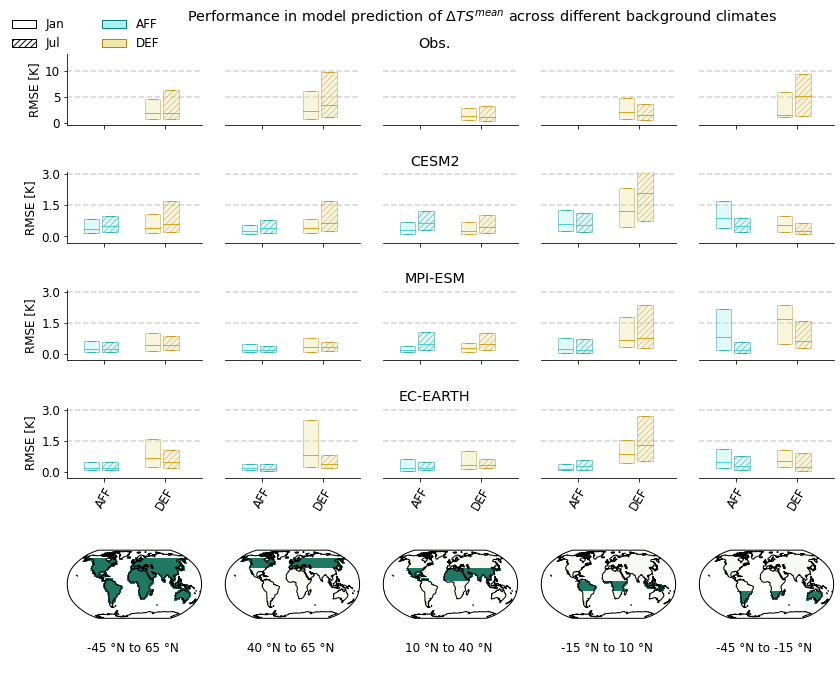

In [16]:
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import skewnorm
import pandas as pd
from matplotlib.patches import Patch

regions=['Global','North\n America','South\n America','Africa\n','Eurasia\n','Australia\n','CGI','Tibet\n','South-East\n Asia']
score='rmse'
colors=plt.cm.plasma(np.linspace(0, 1, 8))
bp={}

white = np.array([248/256, 250/256, 245/256, 1])
blue = np.array([30/256, 120/256, 100/256, 1])

colors = np.vstack((white,blue))
mymap = LinearSegmentedColormap.from_list('my_colormap', colors, N=2)

for var in ['ts_local']:
    
    fs_title=18
    n_row = 4
    n_col=5

    plt.figure(figsize=(16, 13))

    plt.rcParams.update({'font.size': 12})
    plt.rcParams.update({'mathtext.default':'it'}) 


    grid = plt.GridSpec(n_row*6+6, n_col*5+3, wspace=-0.2, hspace=0) # create a grid for the subplots #0.12

    axtext=plt.subplot(grid[:1,5:-5])
    plt.title(r'Performance in model prediction of $\Delta TS^{mean}$ across different background climates',y=0.1)
    plt.axis('off')
    
    axtext=plt.subplot(grid[1:2,2:-5])
    plt.title(r'Obs.',y=0.02)
    plt.axis('off')
    
    axtext=plt.subplot(grid[6:7,2:-5])
    plt.title(r'CESM2',y=0.02)
    plt.axis('off')
    
    axtext=plt.subplot(grid[11:12,2:-5])
    plt.title(r'MPI-ESM',y=0.02)
    plt.axis('off')
    
    axtext=plt.subplot(grid[16:17,2:-5])
    plt.title(r'EC-EARTH',y=0.02)
    plt.axis('off')
    
    
    i_x=2
    bp[var]={}
    
    
    for model in ['Obs','CESM2','MPI-ESM','EC-EARTH']:
        
        i_y=1
        bp[var][model]={}
        
        y_ma = np.full([2,2,idx_l.shape[0],idx_l.shape[1]],np.nan)                
        y_ma[:,:,idx_l]=actual_error[model][score][var][:,[0,6],:]

        for i_reg,lat_vals in enumerate(zip([-45,-15,10,40,-45][::-1],[-15,10,40,65,65][::-1])):
        

            start_lat=np.argwhere(lat_pc==lat_vals[0])[0][0]
            stop_lat=np.argwhere(lat_pc==lat_vals[1])[0][0]

            n_gp=(stop_lat-start_lat)*(len(lon_pc)-1)
        
            bp[var][model][i_reg]={'Aff':[],'Def':[]}


            ax=plt.subplot(grid[i_x:i_x+3,i_y:i_y+4])
            
            
            if model!='Obs':
                arr_aff=y_ma[0,:,start_lat:stop_lat,:]
                arr_aff=arr_aff[~np.isnan(arr_aff)].reshape(2,-1)
                bp[var][model][i_reg]['Aff'].append(ax.boxplot(arr_aff.T,positions=[0.3,0.6],whis=[25,75],showfliers=False,showcaps=True,patch_artist=True,widths = 0.25,))
                #print(arr_aff)

            arr_def=y_ma[1,:,start_lat:stop_lat,:].reshape(2,-1)
            arr_def[:,np.argwhere(np.logical_and(arr_def[0,:]>15,
                                                      arr_def[1,:]>15))]=np.nan
            arr_def=arr_def[:,np.argwhere(np.logical_and(~np.isnan(arr_def[0,:]),
                                                      ~np.isnan(arr_def[1,:])))].reshape(2,-1)


            bp[var][model][i_reg]['Def'].append(ax.boxplot(arr_def.T,positions=[1.3,1.6],whis=[25,75],showfliers=False,showcaps=True,patch_artist=True,widths = 0.25,))

            if model!='Obs':
                for box_aff,box_def in zip(bp[var][model][i_reg]['Aff'],bp[var][model][i_reg]['Def']):
                    plt.setp(box_aff['boxes'], color='teal')


                    for i_patch,patch in enumerate(box_aff['boxes']):
                        
                        if i_patch==1:
                            patch.set(hatch='////',color='teal')
                            
                        patch.set(facecolor='paleturquoise',alpha=0.4)
                    
                    plt.setp(box_aff['medians'],color='mediumturquoise',linewidth=1)
                    plt.setp(box_aff['whiskers'],color='mediumturquoise',linewidth=1)
                    plt.setp(box_aff['caps'],color='mediumturquoise',linewidth=1)

                    plt.setp(box_def['boxes'], color='darkgoldenrod')

                    for i_patch,patch in enumerate(box_def['boxes']):
                       
                        if i_patch==1:
                            patch.set(hatch='////',color='darkgoldenrod')
                            
                        patch.set(facecolor='palegoldenrod',alpha=0.4)
                        
                    plt.setp(box_def['medians'],color='goldenrod',linewidth=1)
                    plt.setp(box_def['whiskers'],color='goldenrod',linewidth=1)
                    plt.setp(box_def['caps'],color='goldenrod',linewidth=1)

            else:
                for box_def in bp[var][model][i_reg]['Def']:

                    plt.setp(box_def['boxes'], color='darkgoldenrod')

                    for i_patch,patch in enumerate(box_def['boxes']):
                        
                        #print(i_patch)
                        if i_patch==1:
                            patch.set(hatch='////',color='darkgoldenrod')
                            
                        patch.set(facecolor='palegoldenrod',alpha=0.4)
                        
                    plt.setp(box_def['medians'],color='goldenrod',linewidth=1)
                    plt.setp(box_def['whiskers'],color='goldenrod',linewidth=1)
                    plt.setp(box_def['caps'],color='goldenrod',linewidth=1)
            
            
            plt.xlim(-0.1,2.1)
            plt.yticks([0,5,10,15])
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            if np.logical_or(lat_vals[0]!=-45,lat_vals[1]!=65):
                ax.spines['left'].set_visible(False)
                ax.tick_params(labelleft=False)
                ax.tick_params(left=False)
            
            plt.xticks([0.5,1.5],labels=['',''],rotation=60)
            if model=='EC-EARTH':
                plt.xticks([0.5,1.5],labels=['AFF','DEF'],rotation=60)
            
            if np.logical_and(lat_vals[0]==-45,lat_vals[1]==65):    
                plt.ylabel('RMSE [K]')

            if model=='Obs' :
                plt.ylim(-0.3,13.3)
                plt.yticks([0,5,10])
                plt.hlines(5,-0.1,2.1,linestyle='--',color='lightgrey')
                plt.hlines(10,-0.1,2.1,linestyle='--',color='lightgrey')
                #plt.hlines(15,-0.1,2.1,linestyle='--',color='lightgrey')
            elif model=='CESM2' or model=='EC-EARTH':
                plt.ylim(-0.3,3.1)
                plt.yticks([0,1.5,3])
                plt.hlines(1.5,-0.1,2.1,linestyle='--',color='lightgrey')
                plt.hlines(3,-0.1,2.1,linestyle='--',color='lightgrey')

            elif model=='MPI-ESM':
                plt.ylim(-0.3,3.1)
                plt.yticks([0,1.5,3])
                plt.hlines(1.5,-0.1,2.1,linestyle='--',color='lightgrey')
                plt.hlines(3,-0.1,2.1,linestyle='--',color='lightgrey')
                


            i_y+=5

        i_x+=5
        
    i_y=1
    i_x+=1
    for lat_vals in zip([-45,-15,10,40,-45][::-1],[-15,10,40,65,65][::-1]):
        
        start_lat=np.argwhere(lat_pc==lat_vals[0])[0][0]
        stop_lat=np.argwhere(lat_pc==lat_vals[1])[0][0]
        
        axreg=plt.subplot(grid[i_x:i_x+3,i_y:i_y+4],projection=ccrs.Robinson(central_longitude=0))
        y_ma = np.zeros(idx_l.shape)
        y_ma[start_lat:stop_lat,:]=1
        y_ma = ma.masked_array(y_ma, mask=idx_l==False)
        axreg.coastlines()
        mesh_1=axreg.pcolormesh(lon_pc, lat_pc, y_ma,  cmap=mymap,vmin=0,vmax=1,transform=ccrs.PlateCarree(),rasterized=True)

        plt.title('%i °N to %i °N \n'%(lat_vals[0],lat_vals[1]),rotation=0,fontsize=12,y=-0.8)


        i_y+=5

            
            
            

axlegend=plt.subplot(grid[:1,:1])
plt.legend([Patch(facecolor='white',edgecolor='black'),
       Patch(facecolor='white',edgecolor='black',hatch='////')],['Jan','Jul'],frameon=False,fontsize=12)
plt.axis('off')

axlegend=plt.subplot(grid[:1,3:4])
plt.legend([Patch(facecolor='paleturquoise',edgecolor='teal'),
       Patch(facecolor='palegoldenrod',edgecolor='darkgoldenrod')],['AFF','DEF'],frameon=False,fontsize=12)
plt.axis('off')

plt.savefig('/net/so4/landclim/snath/LCLM-mod_Pictures/reg_extrap_obs_esm.pdf')


# Tree cover evaluation

In [11]:
treefrac_bins=[[-1,-0.8],[-0.8,-0.5],[-0.5,-0.3],[-0.3,-0.15],[-0.15,-0.01],
               [0.01,0.15],[0.15,0.3],[0.3,0.5],[0.5,0.8],[0.8,1]]
extrapolated_error={}


var = 'ts_local'

for model in ['Obs','CESM2','MPI-ESM','EC-EARTH']:
    
    
    if var=='ts_local':
        dir_out_data_mod=dir_data+'ts_'+model+'_idealised_g025/'

    else:

        dir_out_data_mod=dir_data+'tsmn_tsmx_'+model+'_idealised_g025/'
            
    extrapolated_error[model] = joblib.load(dir_out_data_mod+'model_cv_eval_treecov.pkl')

                                           

    


/home/snath/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1392: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/home/snath/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1392: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/home/snath/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1392: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/home/snath/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1392: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/home/snath/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1392: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/home/snath/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1392: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/home/snath/anaconda3/lib/python3.7/site-packages/nu

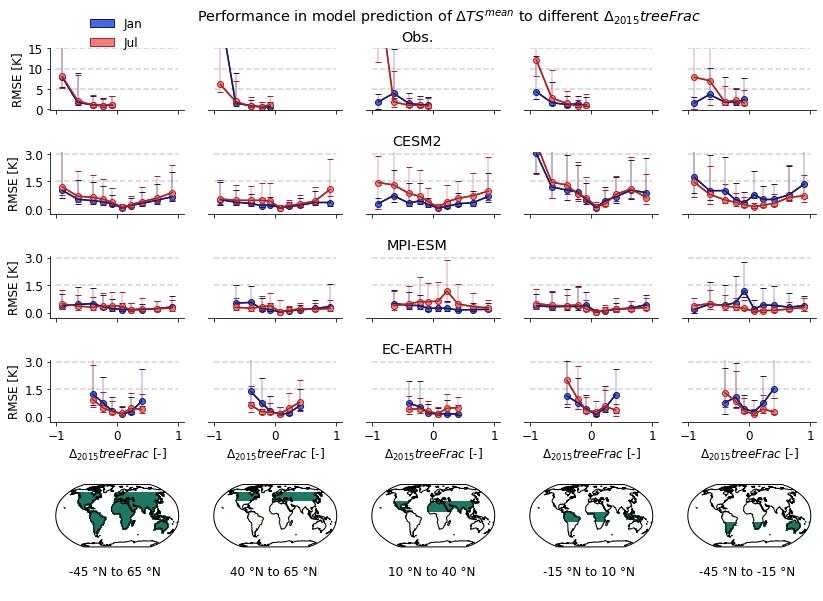

In [14]:
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import skewnorm
import pandas as pd
from matplotlib.lines import Line2D


score='rmse'
colors=plt.cm.Set1(np.linspace(0, 1, 9))
xticks=[-0.9,-0.65,-0.4,-0.225,-0.08,0.08,0.225,0.4,0.65,0.9]

regions=['Global','North\n America','South\n America','Africa\n','Eurasia\n','Australia\n','CGI','Tibet\n','South-East\n Asia']

score='rmse'
colors=plt.cm.plasma(np.linspace(0, 1, 8))


white = np.array([248/256, 250/256, 245/256, 1])
blue = np.array([30/256, 120/256, 100/256, 1])

colors = np.vstack((white,blue))
mymap = LinearSegmentedColormap.from_list('my_colormap', colors, N=2)

for var in ['ts_local']:
    
    fs_title=18
    n_row = 4
    n_col=5

    plt.figure(figsize=(16, 13))

    plt.rcParams.update({'font.size': 12})
    plt.rcParams.update({'mathtext.default':'it'}) 


    grid = plt.GridSpec(n_row*7+6, n_col*5+3, wspace=-0.2, hspace=0) # create a grid for the subplots #0.12

    axtext=plt.subplot(grid[:1,5:-6])
    plt.title(r'Performance in model prediction of $\Delta TS^{mean}$ to different $\Delta_{2015}treeFrac$',y=-0.05)
    plt.axis('off')
    
    axtext=plt.subplot(grid[1:2,2:-5])
    plt.title(r'Obs.',y=0.02)
    plt.axis('off')
    
    axtext=plt.subplot(grid[6:7,2:-5])
    plt.title(r'CESM2',y=0.02)
    plt.axis('off')
    
    axtext=plt.subplot(grid[11:12,2:-5])
    plt.title(r'MPI-ESM',y=0.02)
    plt.axis('off')
    
    axtext=plt.subplot(grid[16:17,2:-5])
    plt.title(r'EC-EARTH',y=0.02)
    plt.axis('off')
    
    i_x=2
    
    for model in ['Obs','CESM2','MPI-ESM','EC-EARTH']:
        
        i_y=1
        y_ma = np.full([10,2,idx_l.shape[0],idx_l.shape[1]],np.nan)                
                
        y_ma[:,:,idx_l]=extrapolated_error[model][var][:,[0,6],:].copy()
       
        #print(i_x)
        for lat_vals in zip([-45,-15,10,40,-45][::-1],[-15,10,40,65,65][::-1]):
        

            start_lat=np.argwhere(lat_pc==lat_vals[0])[0][0]
            stop_lat=np.argwhere(lat_pc==lat_vals[1])[0][0]

            n_gp=(stop_lat-start_lat)*(len(lon_pc)-1)
            
            
            plot_extrapolated_error = np.nanquantile(y_ma[:,:,start_lat:stop_lat,:],0.5,axis=(2,3))
            
            plot_extrapolated_error_bounds = np.zeros([2,10,2])
            plot_extrapolated_error_bounds[0,:,:] = np.nanquantile(y_ma[:,:,start_lat:stop_lat,:],0.25,axis=(2,3))
            plot_extrapolated_error_bounds[1,:,:] = np.nanquantile(y_ma[:,:,start_lat:stop_lat,:],0.75,axis=(2,3))


            ax=plt.subplot(grid[i_x:i_x+3,i_y:i_y+4])
            plt.ylim(-0.3,15.1)
            if model=='Obs':
                plt.yticks([0,5,10,15])
                plt.hlines(5,-1,1,linestyle='--',color='lightgrey')
                plt.hlines(15,-1,1,linestyle='--',color='lightgrey')
                plt.hlines(10,-1,1,linestyle='--',color='lightgrey')

            elif model=='CESM2':
                plt.ylim(-0.3,3.1)
                plt.yticks([0,1.5,3])
                plt.hlines(1.5,-1,1,linestyle='--',color='lightgrey')
                plt.hlines(3,-1,1,linestyle='--',color='lightgrey')
            elif model=='MPI-ESM':
                plt.ylim(-0.3,3.1)
                plt.yticks([0,1.5,3])
                plt.hlines(1.5,-1,1,linestyle='--',color='lightgrey')
                plt.hlines(3,-1,1,linestyle='--',color='lightgrey')
                
            elif model=='EC-EARTH':
                plt.ylim(-0.3,3.1)
                plt.yticks([0,1.5,3])
                plt.hlines(1.5,-1,1,linestyle='--',color='lightgrey')
                plt.hlines(3,-1,1,linestyle='--',color='lightgrey')

            plt.plot(xticks,plot_extrapolated_error[:,0],marker='o',markerfacecolor='royalblue',markeredgecolor='midnightblue',color='midnightblue',linestyle='-')
            plt.errorbar(xticks,plot_extrapolated_error[:,0],yerr=plot_extrapolated_error_bounds[:,:,0],color='midnightblue',ecolor='midnightblue',capsize=3,elinewidth=0.4)
            
            plt.plot(xticks,plot_extrapolated_error[:,1],marker='o',markerfacecolor='lightcoral',markeredgecolor='firebrick',color='firebrick',linestyle='-')
            plt.errorbar(xticks,plot_extrapolated_error[:,1],yerr=plot_extrapolated_error_bounds[:,:,1],color='firebrick',ecolor='firebrick',capsize=3,elinewidth=0.4)
            
            
            plt.xlim(-1.1,1.1)
            
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            if np.logical_or(lat_vals[0]!=-45,lat_vals[1]!=65):
                ax.spines['left'].set_visible(False)
                ax.tick_params(labelleft=False)
                ax.tick_params(left=False)
            
            ax.tick_params(labelbottom=False)
            if model=='EC-EARTH':
                ax.tick_params(labelbottom=True)
                plt.xlabel(r'$\Delta_{2015}treeFrac$ [-]')
            
            if np.logical_and(lat_vals[0]==-45,lat_vals[1]==65):    
                plt.ylabel('RMSE [K]')


            i_y+=5

        i_x+=5
        
    i_y=1
    i_x+=1
    for lat_vals in zip([-45,-15,10,40,-45][::-1],[-15,10,40,65,65][::-1]):
        
        start_lat=np.argwhere(lat_pc==lat_vals[0])[0][0]
        stop_lat=np.argwhere(lat_pc==lat_vals[1])[0][0]

        axreg=plt.subplot(grid[i_x:i_x+3,i_y:i_y+4],projection=ccrs.Robinson(central_longitude=0))
        y_ma = np.zeros(idx_l.shape)
        y_ma[start_lat:stop_lat,:]=1
        y_ma = ma.masked_array(y_ma, mask=idx_l==False)
        axreg.coastlines()
        mesh_1=axreg.pcolormesh(lon_pc, lat_pc, y_ma,  cmap=mymap,vmin=0,vmax=1,transform=ccrs.PlateCarree(),rasterized=True)

        plt.title('%i °N to %i °N \n'%(lat_vals[0],lat_vals[1]),rotation=0,fontsize=12,y=-0.8)


        i_y+=5

            
            
            

axlegend=plt.subplot(grid[:1,3:4])
plt.legend([Patch(facecolor='royalblue',edgecolor='midnightblue'),
       Patch(facecolor='lightcoral',edgecolor='firebrick')],['Jan','Jul'],frameon=False,fontsize=12)
plt.axis('off')


plt.savefig('/net/so4/landclim/snath/LCLM-mod_Pictures/reg_tree_extrap_obs_esm.pdf')
